In [1]:
import pandas as pd
import numpy as np

### Load in Customer Data

In [2]:
customers = pd.read_csv('data/MFG-customers.csv')
customers = customers.loc[:, ['CustomerID', 'City', 'State', 'Country']]
customers['Location'] = customers['State'].fillna(customers['Country']).apply(lambda x: str(x).upper())
customers['City'] = customers['City'].apply(lambda x: str(x).upper())
customers.drop(columns=['State', 'Country'], inplace=True)
 

### Load in Accounts Data

In [3]:
accounts = pd.read_csv('data/MFG-accounts.csv', usecols=['Account_ID', 'Revenue_Class'])

### Load in Invoices Data

In [4]:
invoices = pd.read_csv('data/MFG-invoices.csv', parse_dates=True)
invoices['Date'] = invoices['Date'].apply(pd.Timestamp)
invoices['Month'] = invoices['Date'].apply(lambda x: x.month)
invoices['Year'] = invoices['Date'].apply(lambda x: x.year)
invoices['Day'] = invoices['Date'].apply(lambda x: x.day) 


In [5]:
invoices ['Amount'] = (invoices['Amount'].str.replace(',', '').astype(float)).abs()

In [6]:
invoices['Unit_Price'] = invoices['Unit_Price'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)
invoices['Amount'] = invoices['Amount'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)
invoices['Qty'] = invoices['Qty'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)


### Load in Industry + Press Release Data

In [7]:
industry = pd.read_csv('data/MFG-industry.csv')

In [8]:
press_release = pd.read_csv('data/Press_Release.csv')

In [9]:
press_release['Release Date'] = press_release['Release Date'].apply(pd.Timestamp)
press_release['Month'] = press_release['Release Date'].apply(lambda x: x.month)
press_release['Year'] = press_release['Release Date'].apply(lambda x: x.year)
press_release['Topic_PR'] = press_release['Column1']

In [10]:
press_release.drop(columns=['PR ID', 'Status', 'Last Modified','Premium','Headline', 'Column1'], inplace=True)

In [15]:
press_encoder = Encoder(['Topic_PR'])
press_encoder.fit(press_release)
pr = press_encoder.transform(press_release)
pr = pr.groupby(['Year','Month']).sum().reset_index()

### Create Target Variable

In [16]:
n_days = 90
min_diff_days = 3
repeat=[]
for invoice in invoices.iterrows():
    repeat.append((
        (invoice[1]['CustID'] == invoices['CustID']) 
        & (invoice[1]['Date'] < invoices['Date']) 
        & (invoices['Date'] - invoice[1]['Date'] < pd.Timedelta(n_days, 'd'))
        & (invoices['Date'] - invoice[1]['Date'] > pd.Timedelta(min_diff_days, 'd'))
    ).any())  
    

### Feature Engineering

In [17]:
first_invoice_date = invoices.groupby('CustID')['Date'].min()
customers['First_Invoice'] = first_invoice_date[customers['CustomerID']].values

# days_since_last = invoices.groupby('CustID').apply(lambda x: np.diff(pd.Series.sort_values(x['Date']).values))

In [18]:
total_cust = invoices.groupby('CustID')['Amount'].sum()
invoices['Total_cust'] =  total_cust[invoices['CustID']].values

mean_cust = invoices.groupby('CustID')['Amount'].mean()
invoices['Mean_cust'] =  mean_cust[invoices['CustID']].values

In [22]:
#here I used a merge db
total_rev_class = X.groupby('Revenue_Class')['Amount'].agg('sum')
mean_rev_class = X.groupby('Revenue_Class')['Amount'].agg('mean')

In [23]:
X.groupby('Revenue_Class')['CustID']
X.groupby('Item_ID')['CustID']

KeyError: 'Column not found: CustID'

In [223]:
#press_release.sort_values(['Year', 'Month']).head(20)

### Merge Data

In [19]:
X = invoices.merge(customers, how='left', left_on=['CustID'], right_on=['CustomerID'])
X = X.merge(accounts, how='left', on=['Account_ID'])
X = X.merge(industry, how='left', left_on=['CustID'],right_on=['CustID'])
X = X.merge(pr, how='left', left_on=['Year','Month'], right_on=['Year','Month'])
X.drop(columns=['CustID', 'CustomerID'], inplace=True)
y = pd.Series(repeat, dtype=int)

In [365]:
#X['ttl_amount_cust'] = total_cust#total_cust.loc[X['CustID'].values].values

In [20]:
cutoff_date = X['Date'].max() - pd.Timedelta(n_days, 'd')

Since we don't have enough data after this date, we can't include it in our training set.

In [21]:
y = y[X['Date'] < cutoff_date]
X = X[X['Date'] < cutoff_date]

X.drop(columns=['Date'], inplace=True)

### Split Data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [24]:
def clean_nan(X, y):
    X['Item_ID'] = X['Item_ID'].astype(str)
    X['Revenue_Class'] = X['Revenue_Class'].astype(str)
    y = y[~X.isna().any(axis=1)]
    X.dropna(inplace=True)
    return X, y

In [14]:
class Encoder():
    def __init__(self, columns):
        self.encoder = None 
        self.col_names = None
        self.columns = columns
        self.values = []
    
    def fit(self, X):
        X = X.loc[:, self.columns].astype(str)
        self.values = [np.unique(X[col]) for col in X] 
        self.encoder = OneHotEncoder(categories=self.values, handle_unknown='ignore')
        
        self.encoder.fit(X)
        col_names = []
        for column, values in zip(self.columns, self.values):
            for value in values:
                
                col_names.append(f'{column}_{value}') 
        self.col_names = col_names 
        
    def transform(self, X):
        ar = self.encoder.transform(X.loc[:, self.columns].astype(str))
        ar = ar.todense()
        X = X.drop(columns=self.columns)
        for i, col in enumerate(self.col_names):
            X[col] = ar[:, i]
        return X
    

In [25]:
categorical_features = ['Item_ID', 'Month', 'Year', 
                        'Location', 'Revenue_Class',
                        'City', 'Item_ID', 'Account_ID', 
                        'Industry','First_Invoice']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
X_train, y_train = clean_nan(X_train, y_train)
X_test, y_test = clean_nan(X_test, y_test)

/Users/lulu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lulu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lulu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyda

In [28]:
encoder = Encoder(categorical_features)

In [29]:
encoder.fit(X_train)

In [30]:
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

## Modeling

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

### Random Forest

In [58]:
rf = RandomForestClassifier(1000)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
log_loss(y_test, rf.predict_proba(X_test)[:, 1])

0.1548271552681142

In [35]:
rf6 = RandomForestClassifier(2700)
rf6.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
log_loss(y_test, rf6.predict_proba(X_test)[:, 1])

0.15461893128882898

In [71]:
train_predictions_rf6 = rf6.predict(X_train)
test_predictions_rf6 = rf6.predict_proba(X_test)
train_probas_rf6 = rf6.predict_proba(X_train)
test_probas_rf6 = rf6.predict_proba(X_test)

In [72]:
test_probas_rf6 = rf6.predict_proba(X_test)[:, 1]

In [73]:
threshold = 0.5
model_results_rf6 = pd.DataFrame(np.column_stack((test_probas_rf6,
                                              test_probas_rf6 >= threshold,
                                              y_test)))
model_results_rf6.columns = ['probabilities','predictions','actuals']
model_results_rf6.head()

,probabilities,predictions,actuals
0,0.991111,1.0,1.0
1,0.917407,1.0,1.0
2,0.995926,1.0,1.0
3,0.999630,1.0,1.0
4,0.942593,1.0,1.0


### Gradient Boost

In [50]:
gb = GradientBoostingClassifier(n_estimators=1002, max_depth=4)

In [51]:
cross_val_score(gb, X_train, y_train, cv=3, scoring='neg_log_loss')

array([-0.14028489, -0.24526612, -0.1833234 ])

In [52]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1002,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [53]:
log_loss(y_test, gb.predict_proba(X_test)[:, 1])

0.15596526099190824

In [37]:
gb1= GradientBoostingClassifier(n_estimators=4000, max_depth=4)

In [38]:
cross_val_score(gb1, X_train, y_train, cv=3, scoring='neg_log_loss')

array([-0.21434432, -0.48896977, -0.35875581])

In [39]:
gb1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=4000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [40]:
log_loss(y_test, gb1.predict_proba(X_test)[:, 1])

0.281191589925794

In [41]:
np.argmin([log_loss(y_test, y_pred) for y_pred in gb1.staged_predict_proba(X_test)])

1002

In [68]:
train_predictions_gb = gb.predict(X_train)
test_predictions_gb = gb.predict_proba(X_test)
train_probas_gb = gb.predict_proba(X_train)
test_probas_gb = gb.predict_proba(X_test)

In [69]:
test_probas_gb = gb.predict_proba(X_test)[:, 1]

In [70]:
threshold = 0.5
model_results_gb = pd.DataFrame(np.column_stack((test_probas_gb,
                                              test_probas_gb >= threshold,
                                              y_test)))
model_results_gb.columns = ['probabilities','predictions','actuals']
model_results_gb.head()

,probabilities,predictions,actuals
0,0.983529,1.0,1.0
1,0.991425,1.0,1.0
2,0.997636,1.0,1.0
3,0.996822,1.0,1.0
4,0.981362,1.0,1.0


### Logistic Regression

In [42]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
##LOG LOSS
log_loss(y_test, log_reg.predict_proba(X_test)[:, 1])

0.3643950789482282

In [44]:
train_predictions = log_reg.predict(X_train)
test_predictions = log_reg.predict_proba(X_test)
train_probas = log_reg.predict_proba(X_train)
test_probas = log_reg.predict_proba(X_test)

In [45]:
test_probas = log_reg.predict_proba(X_test)[:, 1]

In [46]:
threshold = 0.5
model_results = pd.DataFrame(np.column_stack((test_probas,
                                              test_probas >= threshold,
                                              y_test)))
model_results.columns = ['probabilities','predictions','actuals']
model_results.head()

,probabilities,predictions,actuals
0,0.835786,1.0,1.0
1,0.695088,1.0,1.0
2,0.998211,1.0,1.0
3,0.981529,1.0,1.0
4,0.887704,1.0,1.0


### Roc Curve

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

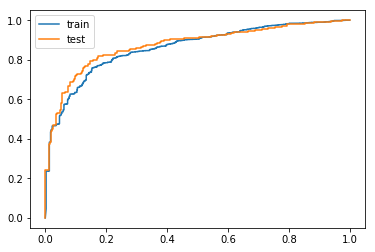

In [56]:
#Logistic Regression
fpr, tpr, threshold = roc_curve(y_train, log_reg.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [74]:
roc_auc_score(model_results.actuals.values, model_results.probabilities.values)

0.8746790052053209

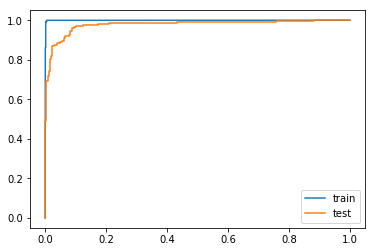

In [54]:
#Gradient Boost
fpr, tpr, threshold = roc_curve(y_train, gb.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [76]:
roc_auc_score(model_results_gb.actuals.values, model_results_gb.probabilities.values)

0.9768652400231347

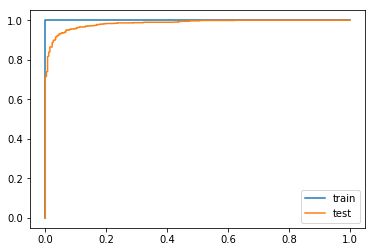

In [60]:
#RandomForest
fpr, tpr, threshold = roc_curve(y_train, rf6.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, rf6.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [77]:
roc_auc_score(model_results_rf6.actuals.values, model_results_rf6.probabilities.values)

0.9845479082321188

## Profic Curves

### Logistic Regression

In [62]:
model_results['category'] = 'Other'

In [63]:
model_results.loc[(model_results.predictions == True) & (model_results.actuals == True),'category'] = 'TP'
model_results.loc[(model_results.predictions == True) & (model_results.actuals == False),'category'] = 'FP'
model_results.loc[(model_results.predictions == False) & (model_results.actuals == False),'category'] = 'TN'
model_results.loc[(model_results.predictions == False) & (model_results.actuals == True),'category'] = 'FN'
model_results.head()

,probabilities,predictions,actuals,category
0,0.835786,1.0,1.0,TP
1,0.695088,1.0,1.0,TP
2,0.998211,1.0,1.0,TP
3,0.981529,1.0,1.0,TP
4,0.887704,1.0,1.0,TP


In [64]:
pd.DataFrame(model_results.category.value_counts())

,category
TP,954
FP,211
TN,55
FN,21


### GB

In [78]:
model_results_gb['category'] = 'Other'

In [79]:
model_results_gb.loc[(model_results_gb.predictions == True) & (model_results_gb.actuals == True),'category'] = 'TP'
model_results_gb.loc[(model_results_gb.predictions == True) & (model_results_gb.actuals == False),'category'] = 'FP'
model_results_gb.loc[(model_results_gb.predictions == False) & (model_results_gb.actuals == False),'category'] = 'TN'
model_results_gb.loc[(model_results_gb.predictions == False) & (model_results_gb.actuals == True),'category'] = 'FN'
model_results_gb.head()

,probabilities,predictions,actuals,category
0,0.983529,1.0,1.0,TP
1,0.991425,1.0,1.0,TP
2,0.997636,1.0,1.0,TP
3,0.996822,1.0,1.0,TP
4,0.981362,1.0,1.0,TP


In [80]:
pd.DataFrame(model_results_gb.category.value_counts())

,category
TP,952
TN,229
FP,37
FN,23


### Random Forest

In [82]:
model_results_rf6['category'] = 'Other'

In [83]:
model_results_rf6.loc[(model_results_rf6.predictions == True) & (model_results_rf6.actuals == True),'category'] = 'TP'
model_results_rf6.loc[(model_results_rf6.predictions == True) & (model_results_rf6.actuals == False),'category'] = 'FP'
model_results_rf6.loc[(model_results_rf6.predictions == False) & (model_results_rf6.actuals == False),'category'] = 'TN'
model_results_rf6.loc[(model_results_rf6.predictions == False) & (model_results_rf6.actuals == True),'category'] = 'FN'
model_results_rf6.head()

,probabilities,predictions,actuals,category
0,0.991111,1.0,1.0,TP
1,0.917407,1.0,1.0,TP
2,0.995926,1.0,1.0,TP
3,0.999630,1.0,1.0,TP
4,0.942593,1.0,1.0,TP


In [85]:
pd.DataFrame(model_results_rf6.category.value_counts())

,category
TP,956
TN,217
FP,49
FN,19


## Clustering

In [126]:
import itertools
import scipy.stats as scs
#from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from src.cluster_generators import make_gaussian_clusters
from src.multihist import multihist
from src.silhouette import make_silhouette_plot

In [183]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
X.head()

,Qty,Unit_Price,Item_ID,Account_ID,Amount,CustID,Month,Year,Day,CustomerID,City,Location,First_Invoice,Revenue_Class,Industry
0,1.0,1695.00,RP-SLA-1,2004040,1695.00,686006,7,2015,1,686006,BAILEY,CO,2015-07-01,3D Printing,Individual
1,1.0,66.91,SHP-MFG,2004210,66.91,686006,7,2015,1,686006,BAILEY,CO,2015-07-01,Freight,Individual
2,1.0,23080.00,RP-INJMOLD-1,2004041,23080.00,487033,7,2015,2,487033,PHOENIX,AZ,2015-07-02,Molding,Consumer Product
3,1.0,3850.00,RP-INJMOLD-1,2004041,3850.00,487033,7,2015,2,487033,PHOENIX,AZ,2015-07-02,Molding,Consumer Product
4,1.0,7830.15,RP-INJMOLD-1,2004041,7830.15,487033,7,2015,2,487033,PHOENIX,AZ,2015-07-02,Molding,Consumer Product


In [118]:
X['Location'].unique()

array(['CO', 'AZ', 'UT', 'CA', 'NAN', 'MA', 'OH', 'NJ', 'PA', 'GERMANY',
       'FL', 'IL', 'TN', 'NE', 'MD', 'IN', 'WA', 'NC', 'GA', 'NM',
       'COSTA RICA', 'MI', 'WI', 'NV', 'NH', 'TE', 'TX', 'KS', 'MN', 'SC',
       'MO', 'CHINA', 'NS', 'OR', 'VA', 'LA', 'PHILIPPINES', 'ON', 'NY',
       'BC'], dtype=object)

In [114]:
X['Account_ID'] = X['Account_ID'].apply(
    lambda x: x.replace('-', '') if isinstance(x, str) else x
).astype(int)

In [181]:
km = KMeans(5)
km.fit(X_train[['Qty', 'Unit_Price']])
labels = km.predict(X_train[['Qty', 'Unit_Price']])

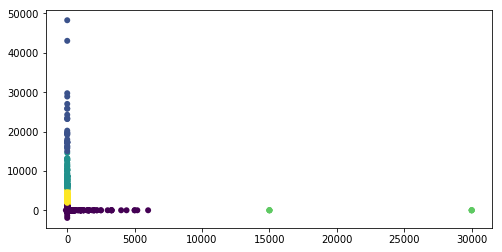

In [191]:
fig, ax = plt.subplots(figsize=(8, 4))

#ax.axis('off')
#ax.axis('equal')
ax.scatter(X_train.values[:,0], X_train.values[:,1], c=labels, linewidths=0)

plt.show()

### Feature importance

In [74]:
#from sklearn.linear_model import Lasso

In [75]:
#lasso_regularization_strengths = np.logspace(np.log10(0.00001), np.log10(10), num=100)

#lasso_regressions = []
#for alpha in lasso_regularization_strengths:
#    lasso = Lasso(alpha=alpha)
#    lasso.fit(X_train, y_train)
#    lasso_regressions.append(lasso)



In [76]:
#def plot_solution_paths(ax, regressions, columns):
#    alphas = [np.log10(ridge.alpha) for ridge in regressions]
#    coeffs = np.concatenate([ridge.coef_.reshape(1, -1) 
#                             for ridge in regressions])
#    for i,idx in enumerate(range(coeffs.shape[1])):
#        name = columns[i]
#        ax.plot(alphas, coeffs[:, idx], label = name)
#    ax.set_xlabel(r"$\log_{10}(\alpha)$")
#    ax.set_ylabel("Estiamted Coefficient")
#    ax.set_title("Coefficient Paths")
#    ax.legend(loc = 5)

In [77]:
#columns = list(X_train.columns)
#fig, ax = plt.subplots(figsize=(16, 6))
#plot_solution_paths(ax, lasso_regressions, columns)

In [78]:
# Get Feature Importance
#coefs = []
#for reg in lasso_regressions:
#    coefs.append(reg.coef_)
#coefs = pd.DataFrame(coefs)
#coefs.columns = list(X_train.columns)
#np.sum(np.round(np.abs(coefs),3) > 0,axis = 0).sort_values(ascending = False)